# Sentence similarity

In this notebook, we focus on similarity between sentences. This will be done in 3 different ways. But first, we need to define some general functionalities and import our data

In [ ]:
import cv2
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import re
import pickle
from nltk.stem import PorterStemmer
import math
from tqdm import tqdm

# 1. Load dataset

We train on RSTPreid dataset. In this notebook, we are focussing on sentence embedding
and analyze the similarity between descriptions. 
Due to that, we are not interestered in the images. Only in the descriptions and the matching person ID

## 1.1 RST Preid dataset

In [ ]:
import json
ff=open('data_captions.json')
data=json.load(ff)
dataset=data.copy()

Retrieve description data out of dataset  
Split in training- test and validation set  
    -Training set: **4101 ID's**, **5images/descriptions**  
    -Test set: **200 ID's**, **1000 images/descriptions**  
    -Validation set: **200 ID's**, **1000 images/descriptions**

The validation set will be used to evaluate between the different models that will be visited in this notebook. 
Afterwards the model will be tested on the test set. During training, we will force the model to retain information of the appearance and clothing style and neglect information of the position or state of the person. We do so, since we want to track passenger on a train. Passengers aren't likely to change clothes on a train.., but are likely to take another pose. 

The accuracy on the test set is only indicative, since we don't aim high accuracy on the RSTPreid dataset. Unfortunately, since we lach annotated data of the train car dataset, we cannot train the model by transfer learning to adapt to the specific characteristics of the domain. As such, we can only test the model on the limited hand-annotated train car dataset. So, there is still margin to improve the results

We've also noticed that some data entries are incorrect, containing weird characters. This will also affect the accuracy and training performances. 

In [ ]:
#The data is already splitted in training, testing and validation data
#Every instance consists of an ID, an image, and 2 descriptions. 
#We opt to only retain the first description, since we assume they are independent of each other. 
#Secondly using two descriptions of one image could lead to wrongly put attention on the pose of the person.
descriptions_train=list()
descriptions_val=list()
descriptions_test=list()
idnummer_train = np.empty([0,1],dtype='int')
idnummer_val = np.empty([0,1],dtype='int')
idnummer_test = np.empty([0,1],dtype='int')
idnummer=np.empty(len(dataset),dtype='int')

for k in tqdm(range(len(dataset))):
    instancedata=[i for i in dataset[k].values()]
    idnummer[k]=int(instancedata[0])
    description=instancedata[2:3]
    if instancedata[3] == 'train':
        descriptions_train += [instancedata[2][0]]
        idnummer_train=np.append(idnummer_train,idnummer[k])
    elif instancedata[3] == 'val':
        descriptions_val += [instancedata[2][0]]
        idnummer_val=np.append(idnummer_val,idnummer[k])
    elif instancedata[3] == 'test':
        descriptions_test += [instancedata[2][0]]
        idnummer_test=np.append(idnummer_test,idnummer[k])

## 1.2 Dataset preprocessing for training

As will become clear furtheron, 
we will train the model in two different ways.  
    1) **Siamese model**: Thereby, we will design pairs of similar descriptions (same ID) as well as pairs of non-similar descriptions (different ID).  
    Another hyperparameter during training is the fraction of positive pairs we want to include in the training set.  
    The label can be -1 (negative pair) or 1 (positive pair). 
    2) **Cross entropy**: Thereby we define a classification layer with output size equal to the number of ID's in the training dataset.  
    Training will be done by defining the categorical cross entropy with the ground true class (one-hot vector)


In [ ]:

import random
from keras.utils import to_categorical
import numpy as np

In order to train the model with categorical cross entropy. We need to create a set of one-hot encoded vectors. The length of the vector equals the number of unique ID's in the training set. 

In [ ]:
def cross_entropy_dataset(descriptions,idnummers):
    idnummers=idnummer_train
    descriptions=descriptions_train
    all_ids=np.unique(idnummers)
    class_numbers = np.array(idnummers)
    one_hot_encoded = to_categorical(class_numbers)
    return one_hot_encoded

In order to train the siamese dataset, we need to create instances consisting of pairs of descriptions. The fraction of positive pairs is a hyperparameter. The labels of negative pairs, descriptions linking to different ID's, are set to -1, forcing the model to increase the distance between them.  

In [ ]:
def siamese_dataset(fraction_pos,descriptions,idnummers):
    all_ids=np.unique(idnummers)
    number_cases=math.floor(len(all_ids)/(2-fraction_pos))
    number_positive_samples=int(fraction_pos*number_cases)
    number_negative_samples=number_cases-number_positive_samples
    indexen_set=range(len(descriptions))
    #Multiple persons will be selected. 
    #For each negative pair, 2 ID's will be selected
    #For each positive pair, 1 ID will be selected. We opt to force to keep the used ID's used in the transformed dataset for all sample pairs different.
    ids_selected=np.random.choice(all_ids, size=number_positive_samples+2*number_negative_samples,replace=False)
    ids_positives=ids_selected[:number_positive_samples]
    ids_negatives=ids_selected[number_positive_samples:]
    pos_indexes=[[0,0]]
    pos_descriptions=[("","")];
    neg_indexes=[[0,0]]
    neg_descriptions=[("","")];
    for k in range(len(ids_positives)):
        pos_index=np.random.choice(np.where(idnummers == ids_positives[k])[0],size=2,replace=False);
        pos_description=[descriptions[pos_index[0]],descriptions[pos_index[1]]];
        pos_descriptions+=[tuple(pos_description)]
        pos_indexes+= [pos_index]  
    del pos_indexes[0], pos_descriptions[0]
    for k in range(int(len(ids_negatives)/2)):
        neg_index=np.zeros(2, dtype=int)
        neg_index[0]=np.random.choice(np.where(idnummers == ids_negatives[k*2])[0],size=1);
        neg_index[1]=np.random.choice(np.where(idnummers == ids_negatives[k*2+1])[0],size=1);
        neg_description=[descriptions[neg_index[0]],descriptions[neg_index[1]]];
        neg_descriptions+=[tuple(neg_description)]
        neg_indexes+= [neg_index]  
    del neg_indexes[0], neg_descriptions[0]    
    descriptions_set=pos_descriptions+neg_descriptions
    descriptions_indexes=pos_indexes+neg_indexes
    indexnumbers=np.arange(0,number_positive_samples+number_negative_samples).astype(int)
    np.random.shuffle(indexnumbers)
    descriptions_set_new=[("","")];
    for k in range(number_negative_samples+number_positive_samples):
        descriptions_set_new+=[descriptions_set[indexnumbers[k]]]
    del descriptions_set_new[0]
    descriptions_set=descriptions_set_new
    ab=np.ones(number_positive_samples,dtype=int)
    bc=np.zeros(number_negative_samples,dtype=int)
    labels_set=np.append(ab,bc)
    labels_set=labels_set[indexnumbers]
    return descriptions_set,labels_set

# 2. Preprocessing of dataset

List of stopwords. These words are very frequent and do not add semantic meaning to sentences. 
For that reason, they are omitted further for sentence embedding. 

In [ ]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

We do some preprocessing of the sentences. 
The main idea is that we remove character combinations that have no added value to understand 
the meaning/semantics of the description. 

In [ ]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',str(text))
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
def remove_punctuation(text):
#     table=str.maketrans('','',string.punctuation)
    txt = text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation))).replace(' '*4, ' ').replace(' '*3, ' ').replace(' '*2, ' ').strip()
#     return text.translate(table)
    return txt
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def final_preprocess(text):
    text = text.replace('\\r', ' ')
    text = text.replace('\\"', ' ')
    text = text.replace('\\n', ' ')
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = ' '.join(e for e in text.split() if e.lower() not in stopwords)
    text = text.lower()
    ps = PorterStemmer()
    text = ps.stem(text)
    return text

In [ ]:
def preprocess_sentence(descriptions):
    descriptions_preprocessed=list()
    for k in range(len(descriptions)):
        description=descriptions[k]
        description=remove_URL(description)
        description=remove_emoji(description)
        description=remove_html(description)
        description=remove_punctuation(description)
        description=decontracted(description)
        description=final_preprocess(description)
        descriptions_preprocessed+= [description]
    return descriptions_preprocessed

In [ ]:
descriptions_train_preprocessed=preprocess_sentence(descriptions_train)
descriptions_val_preprocessed=preprocess_sentence(descriptions_val)
descriptions_test_preprocessed=preprocess_sentence(descriptions_test)

# 3. Model validation

In [ ]:
from sklearn.metrics import top_k_accuracy_score

## 3.1. Creation validation/test set

The test as well as validation set consist of 200 ID's.  
Regarding the use case, we are mainly interested in distinguishing between different people.  
As such, the validation set will be constructed in a way that we will choose randomly and indepent for each ID one description (annotated to query set) as well as one description (annoted to gallery set).  
During validation, the embedding of the query set can be combined with the embedding of the gallery set

Note that a random selection is made of the validation set of RSTPreid to create our  processed dataset. However, we need to ensure that we always use the same validation set when comparing the different models. This is the case since we are executing this function only ones. 

In [ ]:
def make_validation_set(descriptions,idnummers):
    all_ids=np.unique(idnummers)
    descriptions_query=list()
    descriptions_gallery=list()
    for k in range(len(all_ids)):
        indexen_selectie=np.random.choice(np.where(idnummers == all_ids[k])[0],size=2,replace=False)
        descriptions_query+=[descriptions[indexen_selectie[0]]]
        descriptions_gallery+=[descriptions[indexen_selectie[1]]]
    return descriptions_gallery,descriptions_query

In [ ]:
descriptions_val_gallery,descriptions_val_query=make_validation_set(descriptions_val_preprocessed,idnummer_val)
descriptions_test_gallery,descriptions_test_query=make_validation_set(descriptions_test_preprocessed,idnummer_test)

## 3.2 Metric

Hyperparameter tuning and model selection wil be done based on ***top 1*** and ***top 5*** and ***top 20 accuracy*** (out of validation set of ***200 ID's***) by comparing the query embeddings with the gallery embeddings.  

In [ ]:
def square_rooted(x):
    return math.sqrt(sum([a*a for a in x]))

def cosine_similarity_cal(x,y):
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    return numerator/float(denominator)

In [ ]:
def metric_scoring(descriptions_query,descriptions_gallery,embedding_model,*args):
    query_embedding=[]
    gallery_embedding=[]
    cosine_similarityscore=np.zeros((len(descriptions_query),len(descriptions_gallery)))
    if args:
        embedder=args[0]
        basemodel=args[1]
        query_embedding=embedding_model(descriptions_query,embedder,basemodel)
        gallery_embedding=embedding_model(descriptions_gallery,embedder,basemodel)
    else:
        query_embedding=embedding_model(descriptions_query)
        gallery_embedding=embedding_model(descriptions_gallery)
    for k in range(len(descriptions_query)):
        deel1=query_embedding[k]
        for l in range(len(descriptions_gallery)):
            a=cosine_similarity_cal(deel1,gallery_embedding[l])
#             print(a)
            cosine_similarityscore[k,l]=cosine_similarity_cal(deel1,gallery_embedding[l])
    y_true=np.arange(0,len(descriptions_query)).astype(int)
    accuracyscores=[top_k_accuracy_score(y_true,cosine_similarityscore,k=1),top_k_accuracy_score(y_true,cosine_similarityscore,k=5),top_k_accuracy_score(y_true,cosine_similarityscore,k=20)]
    return accuracyscores

# 4. Model training

we will train the model in two different ways.  
    1) **Siamese model**: Thereby, we will design pairs of similar descriptions (same ID) as well as pairs of non-similar descriptions (different ID).  
    Another hyperparameter during training is the fraction of positive pairs we want to include in the training set.  
    The label can be 0 (negative pair) or 1 (positive pair)  
    2) **Cross entropy**: Thereby we define a classification layer with output size equal to the number of ID's in the training dataset.  
    Training will be done by defining the categorical cross entropy with the ground true class (one-hot vector)


In [ ]:
# This function will be use to predict embeddings of the validation set
def embeddermodel(descriptions,embedder,basemodel):
    try:
        embedding=list(basemodel(descriptions))
        try:
            embedding = [tensor.numpy() for tensor in embedding]
            embedding=np.vstack(embedding).tolist()  
        except:
            embedding = [list(arr) for arr in embedding]
    except:
        embedding=descriptions
    sentence_embedding=embedder.predict(embedding)
#     sentence_embedding = [elem for sublist in sentence_embedding for elem in sublist]
    return sentence_embedding

In [ ]:
from keras import backend as K
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten,Activation
from IPython.display import clear_output

import tensorflow as tf

def siamese_model_loss(y_true, y_pred):
    distance=tf.norm(y_true-y_pred)
    margin = 1
#     return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))
    return K.mean(y_true * K.square(distance) + (1 - y_true) * K.square(K.maximum(margin - distance, 0)))

In [ ]:
#This function will train the model with categorical cross entropy. 
#We opt here to fix the weights of the model and only learn the weights of the fully connected layer stacked on top of it. 
def transfer_cross_entropy_model(
    descriptions,
    idnummers,
    descriptions_val_query,
    descriptions_val_gallery,
    metric,
    basemodel,
    epochs,
    batchsize,
    hidden_layer_size):
    labels_set=cross_entropy_dataset(descriptions=descriptions,idnummers=idnummers)
    if basemodel!=None:
        xtrain=basemodel(descriptions)
    else:
        xtrain=descriptions
    input_1 = Input(shape=(len(xtrain[0]),))
    hidden_layer=Dense(hidden_layer_size,activation='tanh')(input_1)
    embedding_layer=Dense(len(labels_set[0]),activation='sigmoid')(hidden_layer)
    train_model=Model(inputs=input_1,outputs=embedding_layer)
    optimizer=Adam(learning_rate=0.02)
    train_model.compile(loss='categorical_crossentropy',optimizer=optimizer)
    class ValidationCallback(tf.keras.callbacks.Callback):
        def __init__(self, descriptions_val_query, descriptions_val_gallery, embedder,basemodel):
            super(ValidationCallback, self).__init__()
            self.descriptions_val_query = descriptions_val_query
            self.descriptions_val_gallery = descriptions_val_gallery
            self.embedder=embedder
            self.basemodel=basemodel
            self.acc_val = []  # List to store intermediate predictions
            self.acc_train = []  # List to store intermediate predictions
            self.loss_values = []
        def on_epoch_end(self, epoch, logs=None):
    #         x_val, _ = self.validation_data  # Get validation data
            acc_val=np.zeros((1,3))
            loss_values=logs['loss']
            self.loss_values.append(loss_values)
            acc_val=metric_scoring(descriptions_val_query,descriptions_val_gallery,embeddermodel,embedder,basemodel)
            clear_output(wait=True) 
#             print(cosine_similarityscore)
            self.acc_val.append(acc_val)  # Append predictions to the list
            fig, axes = plt.subplots(1, 2,figsize=(11,6))
            axes[0].plot(self.acc_val)
            axes[0].set_ylabel('Accuracy (-)')
            axes[0].set_xlabel('Epoch')
            axes[0].set_title('Accuracy validation set')
            axes[0].grid(True)
            axes[1].plot(self.loss_values)
            axes[1].set_ylabel('loss (-)')
            axes[1].set_xlabel('Epoch')
            axes[1].set_title('Cross entropy loss training set')
            axes[1].grid(True)
            plt.show()
    # embedder = keras.models.Model(inputs=self.input[0], outputs=model.get_layer(name='embedding_layer').output)
    embedder = Model(inputs=input_1, outputs=hidden_layer)
    # Model(inputs=input_a,outputs=embedding_layer.output)
    # Instantiate the custom callback
    callback = ValidationCallback(descriptions_val_query=descriptions_val_query,descriptions_val_gallery=descriptions_val_gallery,embedder= Model(inputs=input_1,outputs=hidden_layer),basemodel=basemodel)
    history=train_model.fit(xtrain, labels_set, batch_size=batchsize,epochs=epochs,verbose=2,callbacks=[callback])

    return history, callback, train_model


In [ ]:
#Down below, the model is trained based on the siames architecture. Two descriptions are learned in parallel with shared parameters.
#Afterwards, a cosine similarity layer is stacked on top of it. The model is trained to have high similarity for pos. pairs. 
def transfer_extraction_model_siamese(
    fraction_pos,
    descriptions,
    idnummers,
    descriptions_val_query,
    descriptions_val_gallery,
    metric,
    basemodel,
    epochs,
    batchsize,
    hidden_layer_size):
    [descriptions_set,labels_set]=siamese_dataset(fraction_pos=fraction_pos,descriptions=descriptions,idnummers=idnummers)
    labels_set=tf.cast(labels_set, tf.float32)
    descriptions_1=['start']
    descriptions_2=['start']
    for k in range(len(descriptions_set)):
        descriptions_1.append(descriptions_set[k][0])
        descriptions_2.append(descriptions_set[k][1])
    del descriptions_1[0]
    del descriptions_2[0]
    if basemodel!=None:
#         val_query=basemodel(descriptions_val_query)
#         val_gallery=basemodel(descriptions_val_gallery)
        xtrain_1=basemodel(descriptions_1)
        xtrain_2=basemodel(descriptions_2)
    else:
#         val_query=descriptions_val_query
#         val_gallery=descriptions_val_gallery
        xtrain_1=descriptions_1
        xtrain_2=descriptions_2
    x_train=[xtrain_1, xtrain_2]
    input_a = tf.keras.Input(shape=len(xtrain_1[0]))
    input_b = tf.keras.Input(shape=len(xtrain_1[0]))
    embedding_layer = tf.keras.layers.Dense(hidden_layer_size, activation='tanh',name='embedding_layer')
    encoded_a = embedding_layer(input_a)
    encoded_b = embedding_layer(input_b)
    # compute similarity between encoded inputs
    cosine_similarity = tf.keras.layers.Dot(axes=-1, normalize=True)([encoded_a, encoded_b])
    # define model
    siamese_model = tf.keras.models.Model(inputs=[input_a, input_b], outputs=cosine_similarity)
    optimizer=Adam(learning_rate=0.02)
    siamese_model.compile(loss=siamese_model_loss, optimizer=optimizer)
    class ValidationCallback(tf.keras.callbacks.Callback):
        def __init__(self, descriptions_val_query, descriptions_val_gallery, embedder,basemodel):
            super(ValidationCallback, self).__init__()
            self.descriptions_val_query = descriptions_val_query
            self.descriptions_val_gallery = descriptions_val_gallery
            self.embedder=embedder
            self.basemodel=basemodel
            self.acc_val = []  # List to store intermediate predictions
            self.acc_train = []  # List to store intermediate predictions
            self.loss_values = []
        def on_epoch_end(self, epoch, logs=None):
    #         x_val, _ = self.validation_data  # Get validation data
            acc_val=np.zeros((1,3))
    #             val_query = [arr for arr in val_query]
    #             val_gallery = [arr for arr in val_gallery]
    #             val_query = [array.tolist() for array in val_query]
    #             val_gallery = [array.tolist() for array in val_gallery]
    #             val_query=val_query.numpy()
    #             val_gallery=val_gallery.numpy()
    #             for tensor in val_query:
    #                 type(tensor)
    #             val_query = [tensor for tensor in val_query]
    #             val_gallery = [tensor for tensor in val_gallery]
            loss_values=logs['loss']
            self.loss_values.append(loss_values)
            acc_val=metric_scoring(descriptions_val_query,descriptions_val_gallery,embeddermodel,embedder,basemodel)
    #         val_query=embedder(descriptions_val_query,basemodel,embedder)
    #         val_gallery=model_to_prediction(descriptions_val_gallery,basemodel,embedder)
    #         print(val_query[:5])
    #         acc=metric_scoring(val_query,val_gallery,self.embedder)
            clear_output(wait=True) 
#             print(cosine_similarityscore)
            self.acc_val.append(acc_val)  # Append predictions to the list
            fig, axes = plt.subplots(1, 2,figsize=(11,6))
            axes[0].plot(self.acc_val)
            axes[0].set_ylabel('Accuracy (-)')
            axes[0].set_xlabel('Epoch')
            axes[0].set_title('Accuracy validation set')
            axes[0].grid(True)
            axes[1].plot(self.loss_values)
            axes[1].set_ylabel('loss (-)')
            axes[1].set_xlabel('Epoch')
            axes[1].set_title('Siamese model loss training set')
            axes[1].grid(True)
            plt.show()
    # embedder = keras.models.Model(inputs=self.input[0], outputs=model.get_layer(name='embedding_layer').output)
    embedder = Model(inputs=input_a, outputs=embedding_layer.output)
    # Model(inputs=input_a,outputs=embedding_layer.output)
    # Instantiate the custom callback
    callback = ValidationCallback(descriptions_val_query=descriptions_val_query,descriptions_val_gallery=descriptions_val_gallery,embedder= Model(inputs=input_a,outputs=embedding_layer.output),basemodel=basemodel)
    history=siamese_model.fit([xtrain_1,xtrain_2], labels_set, batch_size=batchsize,epochs=epochs,verbose=2,callbacks=[callback])
    outputmodel=tf.keras.Sequential()
    outputmodel.add(basemodel)
    outputmodel.add(embedding_layer)
    return history, callback, outputmodel


In [ ]:
#Only for USE (see later)
# With this model, we are not only training on the FC layer stacked on the used pretrained model
# We are also retrain/adapt the weights of the pretrained model. However, results aren't optimal, 
#since the dataset is too smal to improve the accuracy on the validation set. 
def finetune_cross_entropy_model(
    descriptions,
    idnummers,
    descriptions_val_query,
    descriptions_val_gallery,
    metric,
    model,
    epochs,
    batchsize,
    hidden_layer_size):
    labels_set=cross_entropy_dataset(descriptions=descriptions,idnummers=idnummers)
    basemodel=None
    if basemodel!=None:
        xtrain=basemodel(descriptions)
    else:
        xtrain=tf.constant(descriptions,dtype=tf.string)
#     input_1 = Input(shape=(len(xtrain[0]),))
    input_1=tf.keras.Input(shape=[], dtype=tf.string)
    encoder=hub.KerasLayer(model,trainable=True)
    encoded_1 = encoder(input_1)
    if hidden_layer_size==0:
        embedding_layer=Dense(len(labels_set[0]),activation='sigmoid')(encoded_1)
        hidden_layer=embedding_layer
        train_model=Model(inputs=input_1,outputs=embedding_layer)
    else:
        hidden_layer=Dense(hidden_layer_size,activation='tanh')(encoded_1)
        embedding_layer=Dense(len(labels_set[0]),activation='sigmoid')(hidden_layer)
        train_model=Model(inputs=input_1,outputs=embedding_layer)
    optimizer=Adam(learning_rate=0.02)
    train_model.compile(loss='categorical_crossentropy',optimizer=optimizer)
    class ValidationCallback(tf.keras.callbacks.Callback):
        def __init__(self, descriptions_val_query, descriptions_val_gallery, embedder,basemodel):
            super(ValidationCallback, self).__init__()
            self.descriptions_val_query = descriptions_val_query
            self.descriptions_val_gallery = descriptions_val_gallery
            self.embedder=embedder
            self.basemodel=basemodel
            self.acc_val = []  # List to store intermediate predictions
            self.acc_train = []  # List to store intermediate predictions
            self.loss_values = []
        def on_epoch_end(self, epoch, logs=None):
    #         x_val, _ = self.validation_data  # Get validation data
            acc_val=np.zeros((1,3))
            loss_values=logs['loss']
            self.loss_values.append(loss_values)
            acc_val=metric_scoring(descriptions_val_query,descriptions_val_gallery,embeddermodel,embedder,basemodel)
            clear_output(wait=True) 
#             print(cosine_similarityscore)
            self.acc_val.append(acc_val)  # Append predictions to the list
            fig, axes = plt.subplots(1, 2,figsize=(11,6))
            axes[0].plot(self.acc_val)
            axes[0].set_ylabel('Accuracy (-)')
            axes[0].set_xlabel('Epoch')
            axes[0].set_title('Accuracy validation set')
            axes[0].grid(True)
            axes[1].plot(self.loss_values)
            axes[1].set_ylabel('loss (-)')
            axes[1].set_xlabel('Epoch')
            axes[1].set_title('Siamese model loss training set')
            axes[1].grid(True)
            plt.show()
    # embedder = keras.models.Model(inputs=self.input[0], outputs=model.get_layer(name='embedding_layer').output)
    embedder = Model(inputs=input_1, outputs=hidden_layer)
    # Model(inputs=input_a,outputs=embedding_layer.output)
    # Instantiate the custom callback
    callback = ValidationCallback(descriptions_val_query=descriptions_val_query,descriptions_val_gallery=descriptions_val_gallery,embedder= Model(inputs=input_1,outputs=hidden_layer),basemodel=basemodel)
    history=train_model.fit(xtrain, labels_set, batch_size=batchsize,epochs=epochs,verbose=2,callbacks=[callback])

    return history, callback, train_model


In [ ]:
#Analogously as previous model, but now for the Siamese modelling case. 
def finetune_siamese(
    fraction_pos,
    descriptions,
    idnummers,
    descriptions_val_query,
    descriptions_val_gallery,
    metric,
    model,
    epochs,
    batchsize,
    hidden_layer_size):
    basemodel=None
    [descriptions_set,labels_set]=siamese_dataset(fraction_pos=fraction_pos,descriptions=descriptions,idnummers=idnummers)
    labels_set=tf.cast(labels_set, tf.float32)
    descriptions_1=['start']
    descriptions_2=['start']

    for k in range(len(descriptions_set)):
    #         descriptions_1=np.append(descriptions_1,descriptions_batch[k][0])
        descriptions_1.append(descriptions_set[k][0])
        descriptions_2.append(descriptions_set[k][1])
    del descriptions_1[0]
    del descriptions_2[0]

#         val_query=basemodel(descriptions_val_query)
#         val_gallery=basemodel(descriptions_val_gallery)
    xtrain_1=tf.constant(descriptions_1,dtype=tf.string)
    xtrain_2=tf.constant(descriptions_2,dtype=tf.string)
    x_train=[xtrain_1, xtrain_2]
#     descriptions_train_query=descriptions_1
#     descriptions_train_gallery=descriptions_2
    input_a = tf.keras.Input(shape=[], dtype=tf.string)
    input_b = tf.keras.Input(shape=[], dtype=tf.string)
#     encoder=tf.keras.Sequential([model,
#                                  tf.keras.layers.Dense(hidden_layer_size, activation='tanh')],name='encoder')

    if hidden_layer_size==0:
        encoder=hub.KerasLayer(model,trainable=True)
        encoded_a = encoder(input_a)
        encoded_b = encoder(input_b)
    else:
        tussen=hub.KerasLayer(model,trainable=True)
        tussen_a = tussen(input_a)
        tussen_b = tussen(input_b)
        encoder=tf.keras.layers.Dense(hidden_layer_size, activation='tanh',name='encoder')
        encoded_a=encoder(tussen_a)
        encoded_b=encoder(tussen_b)

    # compute similarity between encoded inputs
    cosine_similarity = tf.keras.layers.Dot(axes=-1, normalize=True)([encoded_a, encoded_b])
    # define model
    siamese_model = tf.keras.models.Model(inputs=[input_a, input_b], outputs=cosine_similarity)
    optimizer=Adam(learning_rate=0.02)
    siamese_model.compile(loss=siamese_model_loss, optimizer=optimizer)
    class ValidationCallback(tf.keras.callbacks.Callback):
        def __init__(self, descriptions_val_query, descriptions_val_gallery, embedder,basemodel):
            super(ValidationCallback, self).__init__()
            self.descriptions_val_query = descriptions_val_query
            self.descriptions_val_gallery = descriptions_val_gallery
            self.embedder=embedder
            self.basemodel=basemodel
            self.acc_val = []  # List to store intermediate predictions
            self.loss_values = []
        def on_epoch_end(self, epoch, logs=None):
    #         x_val, _ = self.validation_data  # Get validation data
            acc_val=np.zeros((1,3))
            loss_values=logs['loss']
            self.loss_values.append(loss_values)
            acc_val=metric_scoring(descriptions_val_query,descriptions_val_gallery,embeddermodel,embedder,basemodel)
            clear_output(wait=True) 
            self.acc_val.append(acc_val)  # Append predictions to the list
            fig, axes = plt.subplots(1, 2,figsize=(11,6))
            axes[0].plot(self.acc_val)
            axes[0].set_ylabel('Accuracy (-)')
            axes[0].set_xlabel('Epoch')
            axes[0].set_title('Accuracy validation set')
            axes[0].grid(True)
            axes[1].plot(self.loss_values)
            axes[1].set_ylabel('loss (-)')
            axes[1].set_xlabel('Epoch')
            axes[1].set_title('Siamese model loss training set')
            axes[1].grid(True)
            plt.show()
    embedder = Model(inputs=input_a, outputs=encoder.output)

    aaa=[xtrain_1,xtrain_2]

    callback = ValidationCallback(descriptions_val_query=descriptions_val_query,descriptions_val_gallery=descriptions_val_gallery,embedder= Model(inputs=input_a,outputs=encoder.output),basemodel=None)
    history=siamese_model.fit([xtrain_1,xtrain_2], labels_set, batch_size=batchsize,epochs=epochs,verbose=2,callbacks=[callback])

    return history, callback, siamese_model


# 5. Model architecture 1: Sentence to vec  
## Glove word embedding + averaging

First methode we will use is a based on the GloVe word embedding. Afterwards, the embeddings are combined in a naive averaging method
first we input the word embeddings:
It consists of 400k words, of which 200 features are learned. 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

## 5.1. Word embedding

In [ ]:
f = open('glove.6B.200d.txt')
k=0
embeddings_index = {}
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vectors representing the embedding for the word
    embeddings_index[word] = coefs
    k=k+1

f.close()
glove_words =  set(embeddings_index.keys())

## 5.2. Word to sentence embedding

Now, we will define a function that will take the average of the word embeddings, to create a final sentence embedding

In [ ]:
def sentence_averaging_embedding(descriptions):
    sentence_data=np.zeros((len(descriptions),200))
    cnt_words =0; # num of words with a valid vector in the descriptoin
    for k in range(len(descriptions)):
        sentence_embedding = np.zeros(200) # as word vectors are of zero length
        description=descriptions[k]
        for word in description.split():
            if word in glove_words:
                sentence_embedding += embeddings_index[word]
                cnt_words += 1
        if cnt_words != 0:
            sentence_embedding /= math.sqrt(cnt_words)
        sentence_data[k,:]=sentence_embedding
    return sentence_data

#### Base accuracy on validation set:

In [ ]:
metric_scoring(descriptions_val_query,descriptions_val_gallery,sentence_averaging_embedding)

The base accuracy of this naive sentence embedding method on the validation set is:  
-***Top-1-accuracy***: 29,5%  
-***Top-5-accuracy***: 41,0%  
-***Top-20-accuracy***: 49,5%


### 5.2.1. Sentence embedding as feature extraction in transfer learning

In this approach, we will use the sentence embedding of Glove as a preprocessing layer.  
The obtained sentence embedding will further be feeded to a dense layer of size ***200**  
We will train for ***100*** epochs, with batch size of ***400***; optimizer Adam ***0,02***

#### Results on validation set; trained with categorical cross entropy:
Results are shown down below. The convergence towards a (local) minimum is quite stable. However, since the training and validation set are small and the metric used while validation is different of the defined loss in the model, the accuracy that we can attain is quite limited. However, we see a slight increase in accuracy compared to the pretrained GloVE.

Accuracy on the validation set is (after 100 epochs):  
-***Top-1-accuracy***: 32,0%  
-***Top-5-accuracy***: 44,0%  
-***Top-20-accuracy***: 52,0%

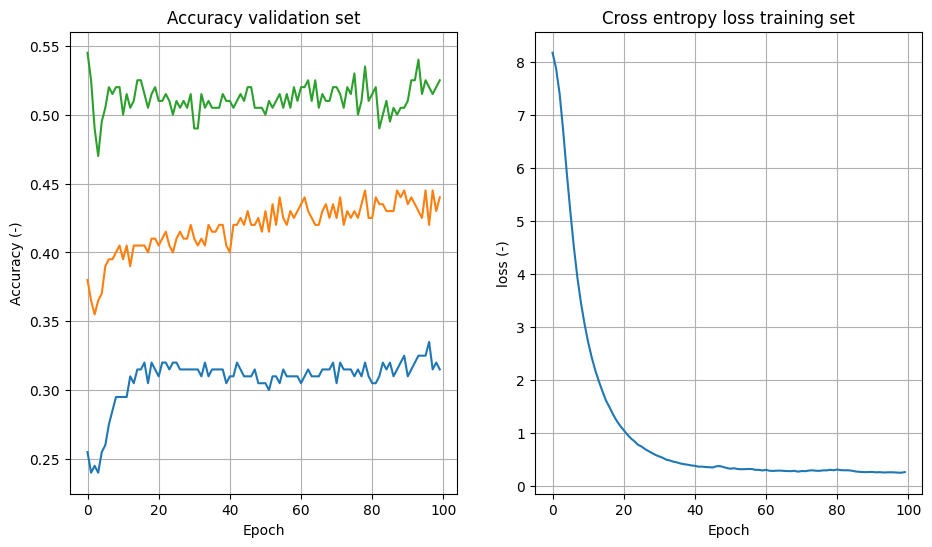

In [ ]:
[history,callback,modelresultaat]=transfer_cross_entropy_model(descriptions=descriptions_train_preprocessed,idnummers=idnummer_train,descriptions_val_query=descriptions_val_query,descriptions_val_gallery=descriptions_val_gallery,metric=metric_scoring,basemodel=sentence_averaging_embedding,epochs=100,batchsize=400,hidden_layer_size=200)


#### Results on validation set; trained with siamese model loss:

As will be seen also further, we obtain quite similar results for both training approaches. The training loss and validation loss are similar. Altough, the siames model tends to be more unstable. 

Accuracy on the validation set is:  
-***Top-1-accuracy***: 30,0%  
-***Top-5-accuracy***: 45,0%  
-***Top-20-accuracy***: 57,0%

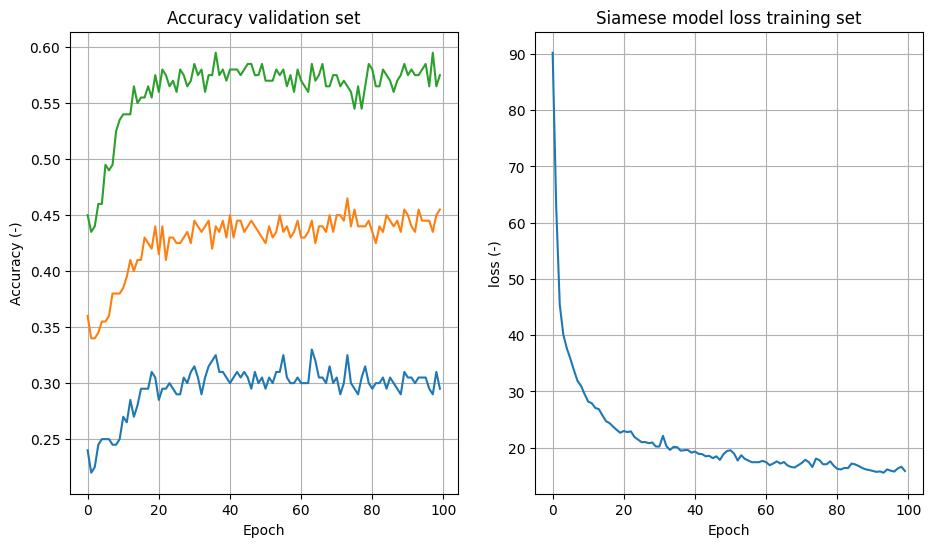

In [ ]:
[history,callback,modelresultaat]=transfer_extraction_model_siamese(fraction_pos=0.5,descriptions=descriptions_train_preprocessed,idnummers=idnummer_train,descriptions_val_query=descriptions_val_query,descriptions_val_gallery=descriptions_val_gallery,metric=metric_scoring,basemodel=sentence_averaging_embedding,epochs=100,batchsize=400,hidden_layer_size=200)


# 6. Model architecture 3: Universal sentence encoder: DAN based


In [ ]:
import tensorflow_hub as hub
USE_DAN_basemodel=hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
use_DAN_module = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=True)


In [ ]:
def USE_DAN(descriptions):
    embeddings=USE_DAN_basemodel(descriptions)
    embeddings=embeddings.numpy()
    return embeddings

#### Base accuracy on validation set:

In [ ]:
metric_scoring(descriptions_val_query,descriptions_val_gallery,USE_DAN)

The base accuracy of this USE_DAN method on the validation set is:  
-***Top-1-accuracy***: 32,5%  
-***Top-5-accuracy***: 40,0%  
-***Top-20-accuracy***: 53%
This is slightly better than GloVe. In GloVe, all words are equally important and no word order information is kept. In DAN, we use bigrams, in that way word order is taken into account

### 6.1: USE DAN as feature extraction for Transfer learning

In this approach, we will use the sentence embedding of USE_DAN as a preprocessing layer.  
The obtained sentence embedding will further be feeded to a dense layer of size ***200**  
We will train for ***100*** epochs, with batch size of ***400***; optimizer Adam ***0,02***

#### Results on validation set; trained with categorical cross entropy:

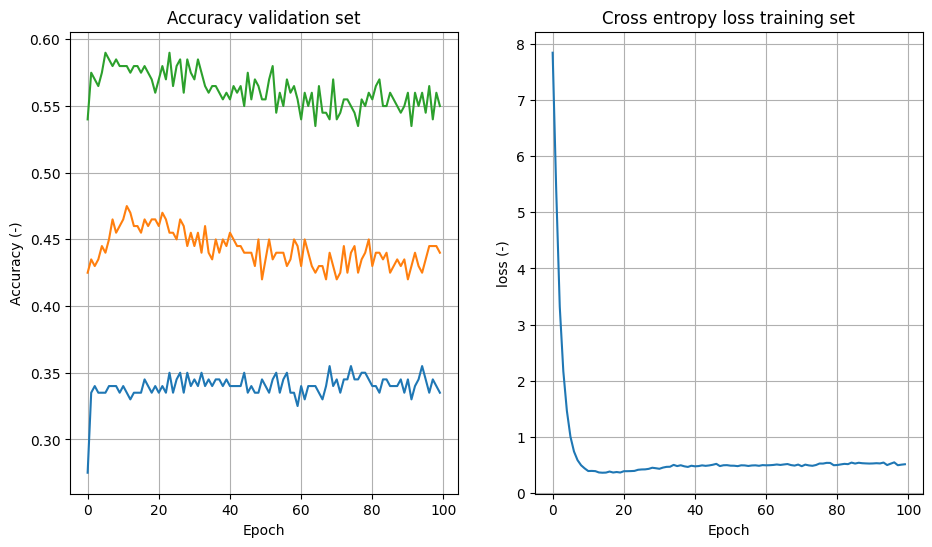


So, the results are slightly better than the pretrained model. The margin to improve the model further is quite small due to the limited dataset.
***In sake of simplicity, the training is done for 100 epochs. Altough, if Early stopping was taken into account, the training shoud stop after 17 epochs. Therefore, I report.  the accuracy at that time. ***

Accuracy on the validation set is:  
-***Top-1-accuracy***: 34,0%  
-***Top-5-accuracy***: 47,0%  
-***Top-20-accuracy***: 57,0%

In [ ]:
[history,callback,modelresultaat]=transfer_cross_entropy_model(descriptions=descriptions_train_preprocessed,idnummers=idnummer_train,descriptions_val_query=descriptions_val_query,descriptions_val_gallery=descriptions_val_gallery,metric=metric_scoring,basemodel=USE_DAN_basemodel,epochs=100,batchsize=400,hidden_layer_size=200)


#### Results on validation set; trained with siamese model loss:


The results are quite comparable for the Siamese model. However the loss is defined differently

As said before, I report results as would be attained if Early stopping was used (22 epochs)

Accuracy on the validation set is:  
-***Top-1-accuracy***: 29,0%  
-***Top-5-accuracy***: 43,5%  
-***Top-20-accuracy***: 56,0%

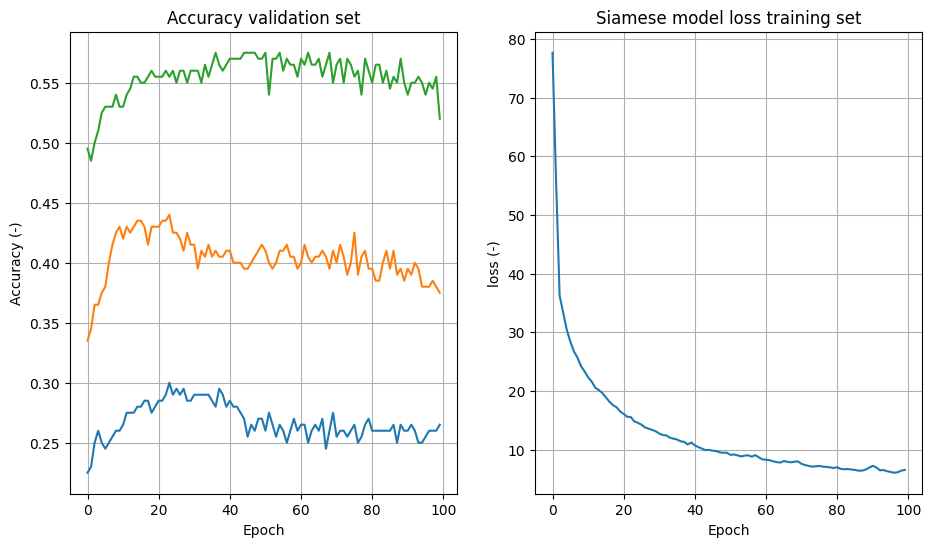

In [ ]:
[history,callback,modelresultaat]=transfer_extraction_model_siamese(fraction_pos=0.5,descriptions=descriptions_train_preprocessed,idnummers=idnummer_train,descriptions_val_query=descriptions_val_query,descriptions_val_gallery=descriptions_val_gallery,metric=metric_scoring,basemodel=USE_DAN_basemodel,epochs=100,batchsize=400,hidden_layer_size=200)


## 6.2. Finetuning USE DAN

In this approach, the weights of USE DAN will be finetuned to increase the performance in the domain of our dataset. 
We distinguish between finetuning the USE DAN-model with and without dense layer stacked to it.

### 6.2.1Training with siamese loss model

In [ ]:
use_DAN_module = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=True)


####  Results on validation set; trained with siamese model; without extra layer:

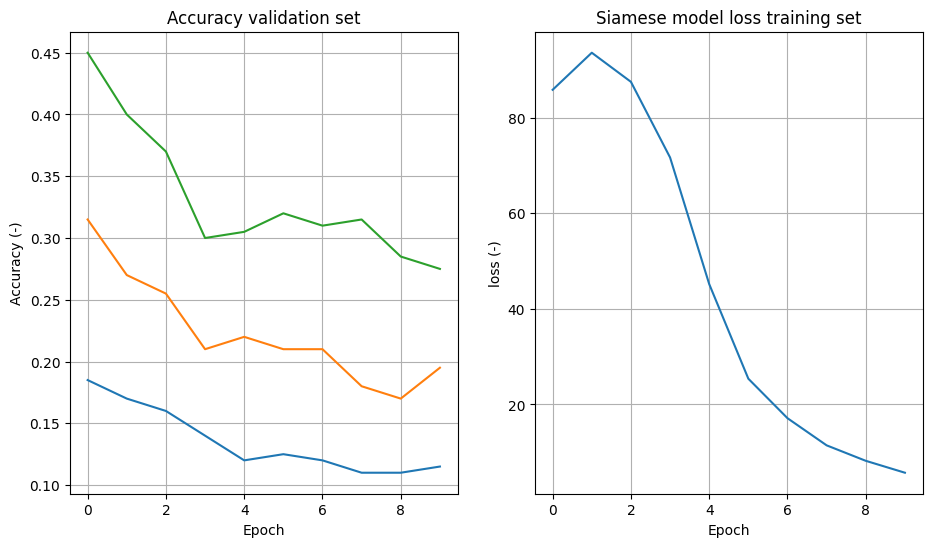

***The results are very poor! The dataset is too limited, which increase the risk of overfitting. That's why the accuracy goes down.. ***

In [ ]:
use_DAN_module = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=True)
[history,callback,modelresultaat]=finetune_siamese(fraction_pos=0.5,descriptions=descriptions_train_preprocessed,idnummers=idnummer_train,descriptions_val_query=descriptions_val_query,descriptions_val_gallery=descriptions_val_gallery,metric=metric_scoring,model=use_DAN_module,epochs=10,batchsize=400,hidden_layer_size=0)


####  Results on validation set; trained with siamese model; with extra layer (200neurons):

Again very poor results; ***Finetuning is not a good approach in our use case***

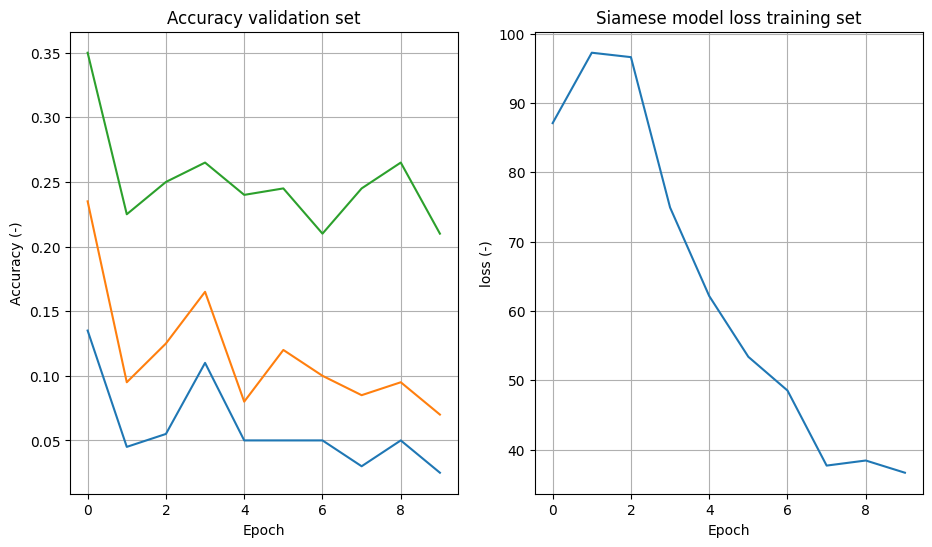

In [ ]:
use_DAN_module = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=True)
[history,callback,modelresultaat]=finetune_siamese(fraction_pos=0.5,descriptions=descriptions_train_preprocessed,idnummers=idnummer_train,descriptions_val_query=descriptions_val_query,descriptions_val_gallery=descriptions_val_gallery,metric=metric_scoring,model=use_DAN_module,epochs=10,batchsize=400,hidden_layer_size=200)


### 6.2.2. Training with cross entropy loss

#### Results on validation set; trained with cross entropy loss; without extra layer:

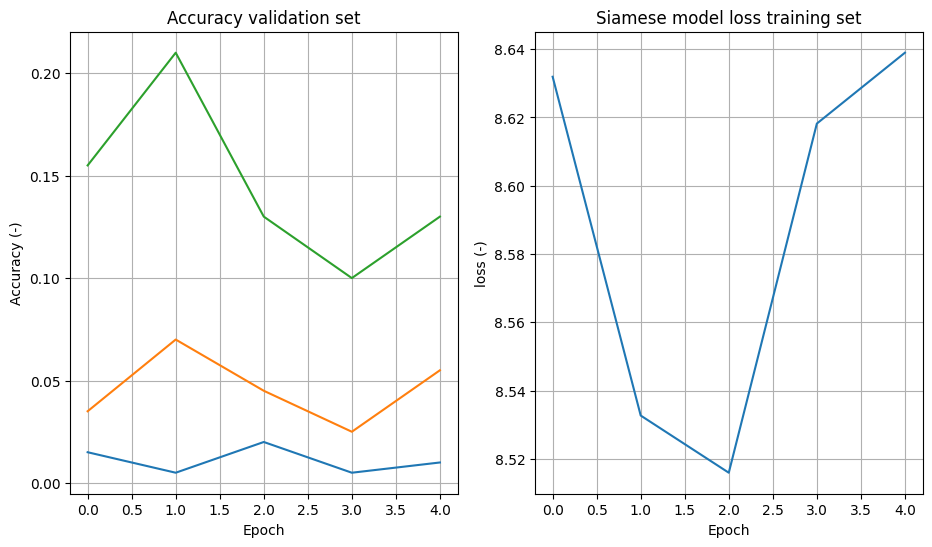

In [ ]:
use_DAN_module = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=True)
[history,callback,modelresultaat]=finetune_cross_entropy_model(descriptions=descriptions_train_preprocessed,idnummers=idnummer_train,descriptions_val_query=descriptions_val_query,descriptions_val_gallery=descriptions_val_gallery,metric=metric_scoring,model=use_DAN_module,epochs=10,batchsize=400,hidden_layer_size=0)


#### Results on validation set; trained with cross entropy loss; with extra layer:

In [ ]:
use_DAN_module = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=True)
[history,callback,modelresultaat]=finetune_cross_entropy_model(descriptions=descriptions_train_preprocessed,idnummers=idnummer_train,descriptions_val_query=descriptions_val_query,descriptions_val_gallery=descriptions_val_gallery,metric=metric_scoring,model=use_DAN_module,epochs=10,batchsize=400,hidden_layer_size=200)


# 7. Model architecture 2: Universal sentence encoder: Transformer based


In [ ]:
import tensorflow_hub as hub
USE_TF_basemodel=hub.load('https://tfhub.dev/google/universal-sentence-encoder-large/5')
USE_TF_module_finetune = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-large/5", trainable=True)
USE_TF_module = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-large/5", trainable=False)

In [ ]:
def USE_TF(descriptions):
    embeddings=USE_TF_basemodel(descriptions)
    embeddings=embeddings.numpy()
    return embeddings

#### Base accuracy on validation set:

In [ ]:
metric_scoring(descriptions_val_query,descriptions_val_gallery,USE_TF)


The base accuracy of this USE_TF method on the validation set is:  
-***Top-1-accuracy***: 34,0%  
-***Top-5-accuracy***: 45,5%  
-***Top-20-accuracy***: 56%

### 7.1: USE TF as feature extraction for transfer learning

In this approach, we will use the sentence embedding of USE_TF as a preprocessing layer.  
The obtained sentence embedding will further be feeded to a dense layer of size ***200**  
We will train for ***100*** epochs, with batch size of ***400***; optimizer Adam ***0,02***

#### Results on validation set; trained with categorical cross entropy:

In [ ]:
[history,callback,modelresultaat]=transfer_cross_entropy_model(descriptions=descriptions_train_preprocessed,idnummers=idnummer_train,descriptions_val_query=descriptions_val_query,descriptions_val_gallery=descriptions_val_gallery,metric=metric_scoring,basemodel=USE_TF_module,epochs=2,batchsize=400,hidden_layer_size=200)


#### Results on validation set; trained with siamese model loss:

If Early stopping was keep in mind, the training would be stopped after 40 epochs:
    
The accuracy on the validation set is:  
-***Top-1-accuracy***: 30,0%  
-***Top-5-accuracy***: 48,0%  
-***Top-20-accuracy***: 63%

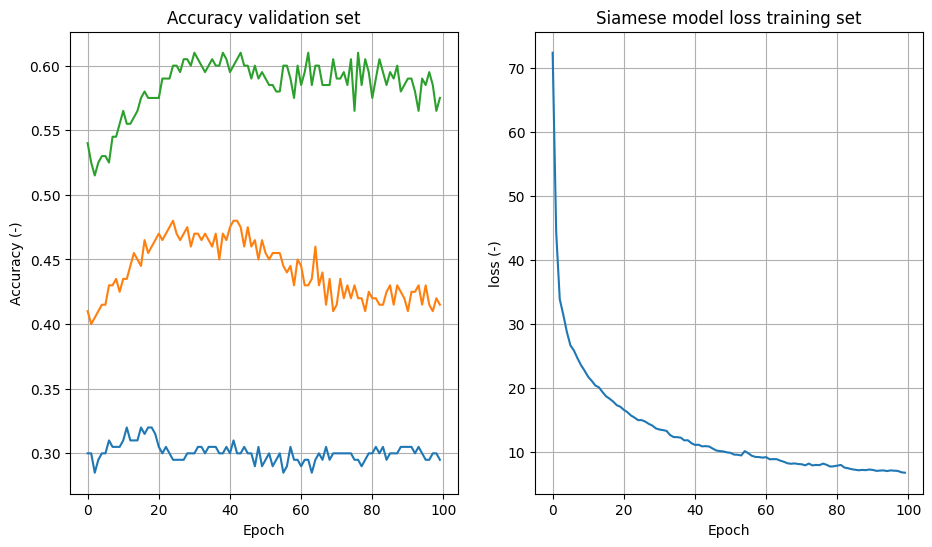

In [ ]:
# [history,callback,modelresultaat]=transfer_extraction_model_siamese(fraction_pos=0.5,descriptions=descriptions_train_preprocessed,idnummers=idnummer_train,descriptions_val_query=descriptions_val_query,descriptions_val_gallery=descriptions_val_gallery,metric=metric_scoring,basemodel=USE_TF_basemodel,epochs=2,batchsize=400,hidden_layer_size=200)
[history,callback,modelresultaat]=transfer_extraction_model_siamese(fraction_pos=0.5,descriptions=descriptions_train_preprocessed,idnummers=idnummer_train,descriptions_val_query=descriptions_val_query,descriptions_val_gallery=descriptions_val_gallery,metric=metric_scoring,basemodel=USE_TF_module2,epochs=40,batchsize=400,hidden_layer_size=200)


Model werd opgeslagen na 40 epochs (wanneer validatieloss afnam). Dit model werd verder gebruikt

In [ ]:
modelresultaat.predict(descriptions_test_query) #dit na 40 epochs

In [ ]:
modelresultaat.save('Model_sentence_similarity')

## 7.2. Finetuning USE TF 

In this approach, the weights of USE TF will be finetuned to increase the performance in the domain of our dataset. 
We distinguish between finetuning the USE TF-model with and without dense layer stacked to it.

### 7.2.1Training with siamese loss model

In [ ]:
use_TF_module = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-large/5", trainable=True)

####  Results on validation set; trained with siamese model; without extra layer:

In [ ]:
use_TF_module = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-large/5", trainable=True)
[history,callback,modelresultaat]=finetune_siamese(fraction_pos=0.5,descriptions=descriptions_train_preprocessed,idnummers=idnummer_train,descriptions_val_query=descriptions_val_query,descriptions_val_gallery=descriptions_val_gallery,metric=metric_scoring,model=use_TF_module,epochs=10,batchsize=400,hidden_layer_size=0)


####  Results on validation set; trained with siamese model; with extra layer (200neurons):

In [ ]:
use_TF_module = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-large/5", trainable=True)
[history,callback,modelresultaat]=finetune_siamesee(fraction_pos=0.5,descriptions=descriptions_train_preprocessed,idnummers=idnummer_train,descriptions_val_query=descriptions_val_query,descriptions_val_gallery=descriptions_val_gallery,metric=metric_scoring,model=use_TF_module,epochs=10,batchsize=400,hidden_layer_size=200)


### 7.2.2. Training with cross entropy loss

#### Results on validation set; trained with cross entropy loss; without extra layer:

In [ ]:
use_TF_module = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-large/5", trainable=True)
[history,callback,modelresultaat]=finetune_cross_entropy_model(descriptions=descriptions_train_preprocessed,idnummers=idnummer_train,descriptions_val_query=descriptions_val_query,descriptions_val_gallery=descriptions_val_gallery,metric=metric_scoring,model=use_TF_module,epochs=10,batchsize=400,hidden_layer_size=0)


#### Results on validation set; trained with cross entropy loss; with extra layer:

In [ ]:
use_TF_module = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-large/5", trainable=True)
[history,callback,modelresultaat]=finetune_cross_entropy_model(descriptions=descriptions_train_preprocessed,idnummers=idnummer_train,descriptions_val_query=descriptions_val_query,descriptions_val_gallery=descriptions_val_gallery,metric=metric_scoring,model=use_TF_module,epochs=10,batchsize=400,hidden_layer_size=200)


# 8. Conclusie

Multiple model architectures as well training approaches are evaluated. We can conclude that the performance of the pretrained models hardly can be improved. This is due to the fact that the dataset is too small in comparison to the high scale of a LM. The best results are obtained with a USE (TF-based) of which we trained 40 epochs. This model is saved and will be used to finally test the performance on the train car dataset. In fact, since we did transfer learning on a particular small dataset, it could be the case that the accuracy will be lower on the train car dataset than if we didn't train anything. 
We will not calculate the performance on the RSTPreid dataset of this model, since our main goal is not to have high accuracy on RSTPreid. 

